In [1]:
#import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob

In [2]:
deeplabv3plus_dir="./src"
sys.path.append(deeplabv3plus_dir)

In [3]:
gpu_options = tf.compat.v1.GPUOptions(visible_device_list="3", allow_growth=True)
config = tf.compat.v1.ConfigProto(gpu_options = gpu_options)
tf.compat.v1.enable_eager_execution(config=config)

In [4]:
#from model import deeplab_v3plus
from data_utils import make_x_from_data_paths,make_y_from_data_paths,convert_y_to_image_array
from data_gen import DataGenerator
from label import Label

In [5]:
from metrics import IoU
from tensorflow.keras.utils import get_custom_objects
get_custom_objects()["IoU"] = IoU

In [6]:
import importlib
importlib.reload(sys.modules['data_utils'])

<module 'data_utils' from './src/data_utils.py'>

In [7]:
model = keras.models.load_model("./polygon_test/000261.h5")

W1205 15:36:38.923532 140736120114384 deprecation.py:323] From /home/taniguchi-j/anaconda3/envs/ppc/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
preprocess = keras.applications.xception.preprocess_input

In [9]:
#model.summary()

In [10]:
traindata_dir = '../kaigan_block/dataset/poly/train'
testdata_dir = '../kaigan_block/dataset/x_test2'

train_x_paths = glob.glob(os.path.join(traindata_dir,'*.jpg'))
train_x_paths.sort()
image_names = [os.path.basename(train_x_paths[i]).split('.')[0] for i in range(len(train_x_paths))]
train_y_paths=[]
for i, image_name in enumerate(image_names):
    p = os.path.join(traindata_dir, image_name+'.json')
    if os.path.exists(p):
        train_y_paths.append(p)
    else:
        train_y_paths.append(None)

In [11]:
label_file_path = os.path.join(traindata_dir, 'label_list.csv')
label = Label(label_file_path)
image_size = (512,512)

In [12]:
'''
label_pd = pd.read_csv("pascal_voc_label.csv", header=None)
label_np = np.array(label_pd.iloc[:,1:])
n_categories = label_pd.shape[0]
image_size = (512,512)
'''

'\nlabel_pd = pd.read_csv("pascal_voc_label.csv", header=None)\nlabel_np = np.array(label_pd.iloc[:,1:])\nn_categories = label_pd.shape[0]\nimage_size = (512,512)\n'

In [13]:
'''
seg_img_dir = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/SegmentationClass"
img_dir = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/JPEGImages"
train_set_path = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
valid_set_path = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"

with open(train_set_path) as f:
    train_img_names = f.read().split("\n")[:-1]
with open(valid_set_path) as f:
    valid_img_names = f.read().split("\n")[:-1]

img_paths = [os.path.join(img_dir,train_img_names[i]) + ".jpg" for i in range(len(train_img_names))]
seg_img_paths = [os.path.join(seg_img_dir,train_img_names[i]) + ".png" for i in range(len(train_img_names))]

valid_x_paths = [os.path.join(img_dir,valid_img_names[i]) + ".jpg" for i in range(len(valid_img_names))]
valid_y_paths = [os.path.join(seg_img_dir,valid_img_names[i]) + ".png" for i in range(len(valid_img_names))]
#valid_x_paths = [os.path.join(img_dir,train_img_names[i]) + ".jpg" for i in range(len(train_img_names))][0:10]
#valid_y_paths = [os.path.join(seg_img_dir,train_img_names[i]) + ".png" for i in range(len(train_img_names))][0:10]
'''

'\nseg_img_dir = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/SegmentationClass"\nimg_dir = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/JPEGImages"\ntrain_set_path = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"\nvalid_set_path = "../pascal_voc_2012_datasets/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"\n\nwith open(train_set_path) as f:\n    train_img_names = f.read().split("\n")[:-1]\nwith open(valid_set_path) as f:\n    valid_img_names = f.read().split("\n")[:-1]\n\nimg_paths = [os.path.join(img_dir,train_img_names[i]) + ".jpg" for i in range(len(train_img_names))]\nseg_img_paths = [os.path.join(seg_img_dir,train_img_names[i]) + ".png" for i in range(len(train_img_names))]\n\nvalid_x_paths = [os.path.join(img_dir,valid_img_names[i]) + ".jpg" for i in range(len(valid_img_names))]\nvalid_y_paths = [os.path.join(seg_img_dir,valid_img_names[i]) + ".png" for i in range(len(valid_img_names))]\n#valid_x_paths = [os.path.join(img_dir,train_img_nam

In [14]:
valid_x = make_x_from_data_paths(train_x_paths, image_size)
valid_y = make_y_from_data_paths(train_y_paths, image_size, label, data_type="polygon")

In [15]:
#valid_x = make_x_from_image_paths(img_paths[0:50], image_size)
#valid_y = make_y_from_image_paths(seg_img_paths[0:50], image_size, n_categories)

In [16]:
valid_y[i,:,:,:].argmax(2)[-10:,0:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
pred = model.predict(preprocess(valid_x))

In [19]:
y_pred = convert_y_to_image_array(pred, image_size, label)
y_true = convert_y_to_image_array(valid_y, image_size, label)

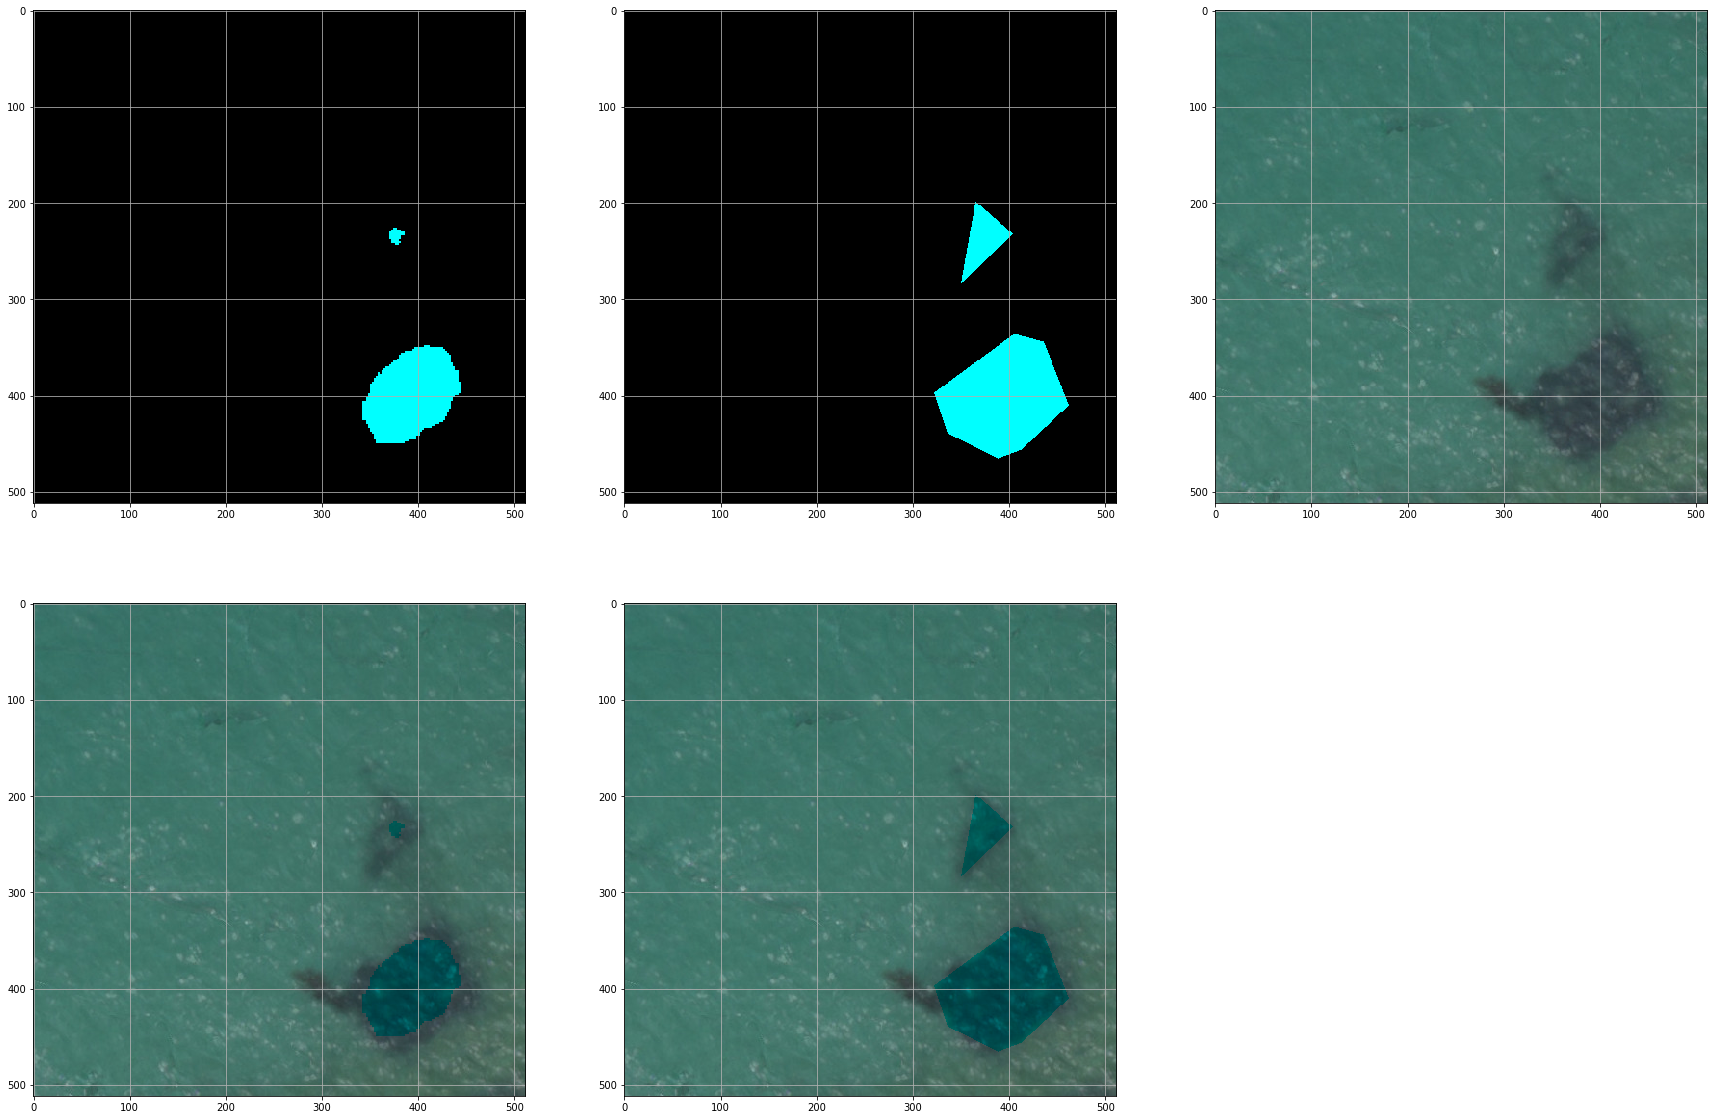

In [23]:
i=0
plt.figure(figsize=(30,20))
plt.subplot(2,3,1)
plt.imshow(y_pred[i])
plt.grid()
plt.subplot(2,3,2)
plt.imshow(y_true[i])
plt.grid()
plt.subplot(2,3,3)
plt.imshow(valid_x[i,:,:,:])
plt.grid()

y_mask = y_pred[i].copy()
black_pix=(y_mask == np.array([0,0,0])).all(axis=2)
y_mask[black_pix,:] = [1.0,1.0,1.0]
plt.subplot(2,3,4)
plt.imshow(y_mask*valid_x[i,:,:,:]/255)
plt.grid()
y_mask = y_true[i].copy()
black_pix=(y_mask == np.array([0,0,0])).all(axis=2)
y_mask[black_pix,:] = [1.0,1.0,1.0]
plt.subplot(2,3,5)
plt.imshow(y_mask*(valid_x[i,:,:,:]/255))
plt.grid()
